In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# 2. Model selection

We will apply the lessons learned during the data exploration to our dataset, before looking into potential regression algorithms for our specific problem.

In [3]:
diam_data = pd.read_csv('diamonds.csv', index_col = 0)
diam_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Our ultimate target is the price, which will be computed as $price/carat \times weight$. For our model, the target will however be the price/carat.

In [4]:
y = np.divide(diam_data['price'], diam_data['carat'])
y.head()

1    1417.391304
2    1552.380952
3    1421.739130
4    1151.724138
5    1080.645161
dtype: float64

In [5]:
X = diam_data.drop(columns=['price'])
X.head()

,carat,cut,color,clarity,depth,table,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75


We know a step is the log-transformation of our target variable.

In [6]:
target_transform = TransformedTargetRegressor(
    regressor=None, #To be set for each model
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

Another step includes binning the 'carat' column, before using it in the model.

Scikit-learn does not have a simple function to achieve this with given bin edges, so we will create one that can be used in a pipeline.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class CustomBinDiscretizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 bins,
                 right: 'bool' = True,
                 labels=None,
                 retbins: 'bool' = False,
                 precision: 'int' = 3,
                 include_lowest: 'bool' = False,
                 duplicates: 'str' = 'raise',
                 ordered: 'bool' = True):
        self.bins = bins
        self.right = right
        self.labels = labels
        self.retbins = retbins
        self.precision = precision
        self.include_lowest = include_lowest
        self.duplicates = duplicates
        self.ordered = ordered

    def fit(self, X, y=None):
        #Nothing to fit, given custom bins
        return self

    def transform(self, X, y=None):
        # if isinstance(X, pd.DataFrame), ("Only pandas dataframes can be used as inputs for this function")
        X_new = pd.DataFrame(X)
        for col in X_new.columns:
            X_new.loc[:, col] = pd.cut(x=X_new.loc[:, col].values, **self.__dict__)
        return X_new

We then initialize this custom class with the relevant parameters.

In [9]:
discretizer = CustomBinDiscretizer(
    labels=False, #No labels, using int ordinal instead directly
    bins=[0, .5, .75, 1, 1.5, 2, +np.inf]
)

Another step involves the imputation, through bayesian ridge regression, of the missing x values, if any.

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [11]:
#Imputation step
imputer = IterativeImputer(missing_values=0, random_state=50)

Depending on the algorithm used, we may also need additional steps:
- Encoding (ordinally, or one-hot) categorical variables
- Standard-scaling numerical values

In [12]:
#Define ordinal order for the encoded categorical variables
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

In [13]:
#Initialize encoders
oh_encoder = OneHotEncoder()
or_encoder = OrdinalEncoder(categories = [cut_order, clarity_order])

In [14]:
#Initialize standard scaler
scaler = StandardScaler()

In [15]:
#Preprocessing steps for columns used in imputer
preprocess_imputer = ColumnTransformer([
    ('discretizer', discretizer, [0]), #Using lists of scalar as column position, as the name gets removed after the first step (imputer)
    ('scaler', scaler, [1])
])

#Combining the two
prep_imputer = Pipeline([
    ('imputer', imputer),
    ('preprocess_imputer', preprocess_imputer)
])

#Overall preprocessing
preprocess = ColumnTransformer(
    [
        ('prep_imputer', prep_imputer, ['carat', 'x']),
        ('oh_encoder', oh_encoder, ['color']),
        ('or_encoder', or_encoder, ['cut', 'clarity']),
        ('scaler', scaler, ['depth', 'table'])
    ],
    remainder='drop'
)

## Models

We can now start looking at potential predictive models based on our dataset.
We will use 80% of the data for training purposes (of which 90% for direct training, 10% for model selection / validation), and the remaining 20% as a test set.
The models will be fit with 5-fold cross-validation on the direct training set, using the mean squared error as the main loss function, and a combination of factors will be used for model selection.

In [16]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=50)

#Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=5)

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

### Stochastic Gradient Descent regressor with elasticnet penalty

In [18]:
#Define the model
sgdr_model = SGDRegressor(
    loss='squared_error',
    penalty='elasticnet',
    random_state=50
)

In [19]:
#Create a pipeline with preprocessing + model
sgdr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', sgdr_model)
])

In [20]:
sgdr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('oh_encoder', OneHotEncoder(),
                                                  ['color']),
                                                 ('or_encoder',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'clarity']),
                                                 ('scaler', StandardScaler(),
                                                  ['depth', 'table'])])),
                ('model', SGDRegressor(penalty='elasticnet', random_state=50))])

In [21]:
#Include the log-transformation of the target into the model
sgdr_pipe_transform = TransformedTargetRegressor(
    regressor=sgdr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [22]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__alpha': np.logspace(-5,0,6),
    'regressor__model__l1_ratio': np.linspace(0.1,0.9,5)
}

In [23]:
#Include the model into the grid search
sgdr_pipe_transform = GridSearchCV(
    sgdr_pipe_transform,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=10
)

In [24]:
sgdr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                                                          'VS1',
                                                                                                                                          'VVS2',
                                                                                                                                          'VVS1',
                                                                                                                                          'IF']]),
                                                                                                              ['cut',
                                                                                                               'clarity']),
                                                                                                             ('scaler',
                                                                                                              StandardScaler(),
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             SGDRegressor(penalty='elasticnet',
                                                                                          random_state=50))])),
             n_jobs=10,
             param_grid={'regressor__model__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'regressor__model__l1_ratio': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='neg_mean_squared_error')

### Partial Least Squares regressor

In [25]:
#Define the model
plsr_model = PLSRegression(
    scale=False
)

In [26]:
#Create a pipeline with preprocessing + model
plsr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', plsr_model)
])

In [27]:
plsr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('oh_encoder', OneHotEncoder(),
                                                  ['color']),
                                                 ('or_encoder',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'clarity']),
                                                 ('scaler', StandardScaler(),
                                                  ['depth', 'table'])])),
                ('model', PLSRegression(scale=False))])

In [28]:
#Include the log-transformation of the target into the model
plsr_pipe_transform = TransformedTargetRegressor(
    regressor=plsr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [29]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__n_components': [2,4,6,8],
}

In [30]:
#Include the model into the grid search
plsr_pipe_transform = GridSearchCV(
    plsr_pipe_transform,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=10
)

In [31]:
plsr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                              ['color']),
                                                                                                             ('or_encoder',
                                                                                                              OrdinalEncoder(categories=[['Fair',
                                                                                                                                          'Good',
                                                                                                                                          'Very '
                                                                                                                                          'Good',
                                                                                                                                          'Premium',
                                                                                                                                          'Ideal'],
                                                                                                                                         ['I1',
                                                                                                                                          'SI2',
                                                                                                                                          'SI1',
                                                                                                                                          'VS2',
                                                                                                                                          'VS1',
                                                                                                                                          'VVS2',
                                                                                                                                          'VVS1',
                                                                                                                                          'IF']]),
                                                                                                              ['cut',
                                                                                                               'clarity']),
                                                                                                             ('scaler'

### KNN regressor

In [32]:
#Define the model
knnr_model = KNeighborsRegressor(
    n_jobs=10
)

In [33]:
#Create a pipeline with preprocessing + model
knnr_pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', knnr_model)
])

In [34]:
knnr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('scaler',
                                                                                                    StandardScaler(),
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('oh_encoder', OneHotEncoder(),
                                                  ['color']),
                                                 ('or_encoder',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']]),
                                                  ['cut', 'clarity']),
                                                 ('scaler', StandardScaler(),
                                                  ['depth', 'table'])])),
                ('model', KNeighborsRegressor(n_jobs=10))])

In [35]:
#Include the log-transformation of the target into the model
knnr_pipe_transform = TransformedTargetRegressor(
    regressor=knnr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [36]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__weights': ['uniform', 'distance'],
}

In [37]:
#Include the model into the grid search
knnr_pipe_transform = GridSearchCV(
    knnr_pipe_transform,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    cv=5
)

In [38]:
knnr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                              ['color']),
                                                                                                             ('or_encoder',
                                                                                                              OrdinalEncoder(categories=[['Fair',
                                                                                                                                          'Good',
                                                                                                                                          'Very '
                                                                                                                                          'Good',
                                                                                                                                          'Premium',
                                                                                                                                          'Ideal'],
                                                                                                                                         ['I1',
                                                                                                                                          'SI2',
                                                                                                                                          'SI1',
                                                                                                                                          'VS2',
                                                                                                                                          'VS1',
                                                                                                                                          'VVS2',
                                                                                                                                          'VVS1',
                                                                                                                                          'IF']]),
                                                                                                              ['cut',
                                                                                                               'clarity']),
                                                                                                             ('scaler'

### Light GBM regressor

In [66]:
X_train

,carat,cut,color,clarity,depth,table,x,y,z
52483,0.73,Premium,H,VS2,61.0,58.0,5.84,5.76,3.54
45589,0.52,Very Good,E,VS2,60.9,57.0,5.17,5.20,3.16
26236,2.02,Very Good,H,SI2,62.7,59.0,8.04,7.98,5.02
53578,0.70,Fair,E,VS2,60.6,64.0,5.77,5.62,3.45
19768,1.65,Ideal,J,SI1,62.5,56.0,7.59,7.54,4.73
...,...,...,...,...,...,...,...,...,...
35560,0.35,Premium,G,VS1,62.3,59.0,4.53,4.49,2.81
17726,0.32,Ideal,H,VVS2,62.3,57.0,4.34,4.37,2.71
4128,1.00,Good,G,SI2,58.1,65.0,6.48,6.46,3.76
51405,0.71,Very Good,F,SI1,63.7,56.0,5.63,5.67,3.60


In [39]:
#Define the model
lgbr_model = LGBMRegressor(
    boosting_type='gbdt',
    n_jobs=10,
    random_state=50
)

Considering the tree-based gradient boosting model used here, we will adapt the preprocessing steps, by removing the transformations that should not have a material impact, and that may increase processing time. Hence, we will only consider the imputation step, removing the encoding steps (no need for specific ordering or one-hot encoding), and the scaling step (tree invariant through standard scaling).

In [72]:
#Adapt preprocessing steps
tree_preprocess_imputer = ColumnTransformer([
    ('discretizer', discretizer, [0]), #Using lists of scalar as column position, as the name gets removed after the first step (imputer)
    ('passthrough', 'passthrough', [1])
])

tree_prep_imputer = Pipeline([
    ('imputer', imputer),
    ('preprocess_imputer', tree_preprocess_imputer)
])

tree_or_encoder = OrdinalEncoder()

tree_preprocess = ColumnTransformer(
    [
        ('prep_imputer', tree_prep_imputer, ['carat', 'x']),
        ('or_encoder', tree_or_encoder, ['color', 'cut', 'clarity']),
        ('passthrough', 'passthrough', ['depth', 'table'])
    ],
    remainder='drop'
)

In [74]:
#Create a pipeline with preprocessing + model
lgbr_pipe = Pipeline([
    ('preprocess', tree_preprocess),
    ('model', lgbr_model)
])

In [75]:
lgbr_pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('prep_imputer',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(missing_values=0,
                                                                                    random_state=50)),
                                                                  ('preprocess_imputer',
                                                                   ColumnTransformer(transformers=[('discretizer',
                                                                                                    CustomBinDiscretizer(bins=[0,
                                                                                                                               0.5,
                                                                                                                               0.75,
                                                                                                                               1,
                                                                                                                               1.5,
                                                                                                                               2,
                                                                                                                               inf],
                                                                                                                         labels=False),
                                                                                                    [0]),
                                                                                                   ('passthrough',
                                                                                                    'passthrough',
                                                                                                    [1])]))]),
                                                  ['carat', 'x']),
                                                 ('or_encoder',
                                                  OrdinalEncoder(),
                                                  ['color', 'cut', 'clarity']),
                                                 ('passthrough', 'passthrough',
                                                  ['depth', 'table'])])),
                ('model', LGBMRegressor(n_jobs=10, random_state=50))])

In [76]:
#Include the log-transformation of the target into the model
lgbr_pipe_transform = TransformedTargetRegressor(
    regressor=lgbr_pipe,
    func=np.log, #Use log-transform
    inverse_func=np.exp #Inverse = exponential
)

In [77]:
#Define parameters grid for the grid search
grid = {
    'regressor__model__max_depth': [10, 50, 100],
    'regressor__model__reg_alpha': np.logspace(-2,0,3),
    'regressor__model__reg_lambda': np.logspace(-2,0,3)
}

In [78]:
#Include the model into the grid search
lgbr_pipe_transform = GridSearchCV(
    lgbr_pipe_transform,
    param_grid=grid,
    scoring='neg_mean_squared_error',
    cv=5
)

In [79]:
lgbr_pipe_transform.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log'>,
                                                  inverse_func=<ufunc 'exp'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             ColumnTransformer(transformers=[('prep_imputer',
                                                                                                              Pipeline(steps=[('imputer',
                                                                                                                               IterativeImputer(missing_values=0,
                                                                                                                                                random_state=50)),
                                                                                                                              ('preprocess_imputer',
                                                                                                                               ColumnTransformer(transformers=[('discretizer',
                                                                                                                                                                CustomBinDiscre...
                                                                                                             ('or_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['color',
                                                                                                               'cut',
                                                                                                               'clarity']),
                                                                                                             ('passthrough',
                                                                                                              'passthrough',
                                                                                                              ['depth',
                                                                                                               'table'])])),
                                                                            ('model',
                                                                             LGBMRegressor(n_jobs=10,
                                                                                           random_state=50))])),
             param_grid={'regressor__model__max_depth': [10, 50, 100],
                         'regressor__model__reg_alpha': array([0.01, 0.1 , 1.  ]),
                         'regressor__model__reg_lambda': array([0.01, 0.1 , 1.  ])},
             scoring='neg_mean_squared_error')

## Model comparison

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from time import time

In [81]:
def compute_model_metrics(model_list, model_name_list, X, y):
    #Initialize empty list
    scores_list = []
    
    assert len(model_list)==len(model_name_list), (f'Mismatch between length of models list ({len(model_list)}) and length of model names list ({len(model_name_list)}).')
    
    for model, name in zip(model_list, model_name_list):
        #For each model, initialize empty dict
        model_dict = {}
        model_dict['model'] = model
        model_dict['name'] = name
        #Compute prediction time
        time0 = time()
        try:
            y_hat = model.predict(X)
        except:
            TypeError("The models must have a model.predict() method associated")
        pred_time = time()-time0
        model_dict['prediction time'] = pred_time
        #Compute metrics
        model_dict['mean squared error'] = mean_squared_error(y, y_hat)
        model_dict['mean abs percent error'] = mean_absolute_percentage_error(y, y_hat)
        model_dict['r squared'] = r2_score(y, y_hat)
        #Add dict to list
        scores_list.append(model_dict)
        
    return scores_list

In [82]:
models = [sgdr_pipe_transform, plsr_pipe_transform, knnr_pipe_transform, lgbr_pipe_transform]
models_names = ['SGD Reg', 'PLS Reg', 'KNN Reg', 'LGBM Reg']

In [83]:
model_metrics = compute_model_metrics(models, models_names, X_valid, y_valid)
model_metrics = pd.DataFrame.from_dict(model_metrics)
model_metrics

,model,name,prediction time,mean squared error,mean abs percent error,r squared
0,"GridSearchCV(cv=5,\n estimator=Tra...",SGD Reg,0.010001,524587.639526,0.119936,0.873673
1,"GridSearchCV(cv=5,\n estimator=Tra...",PLS Reg,0.009000,519719.211158,0.119433,0.874846
2,"GridSearchCV(cv=5,\n estimator=Tra...",KNN Reg,0.189628,286918.357429,0.099903,0.930907
3,"GridSearchCV(cv=5,\n estimator=Tra...",LGBM Reg,0.015000,179553.067644,0.076805,0.956762


In [84]:
model_metrics.columns.drop(['model', 'name'])

Index(['prediction time', 'mean squared error', 'mean abs percent error',
       'r squared'],
      dtype='object')

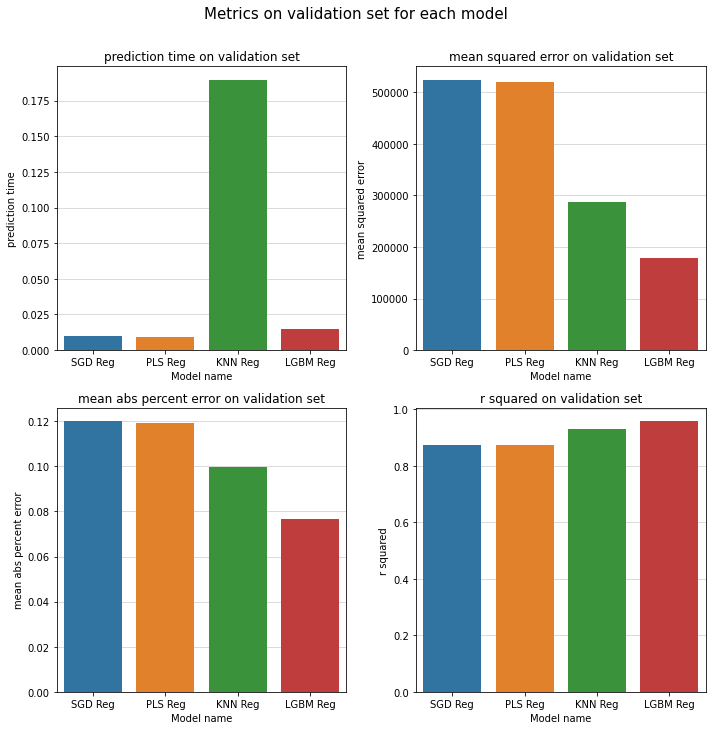

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

for ax, metric in zip(fig.axes, model_metrics.columns.drop(['model', 'name'])):
    
    sns.barplot(
        x=model_metrics['name'].values,
        y=model_metrics[metric],
        ax=ax
    )
    
    ax.set_xlabel("Model name")
    ax.grid(True, axis='y', color='lightgrey')
    ax.set_axisbelow(True)
    ax.set_title(f'{metric} on validation set')

fig.set_tight_layout(True)
fig.suptitle('Metrics on validation set for each model', y=1.01, fontsize=15)

plt.show()